In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torchvision.models import resnet18
from sklearn.metrics import accuracy_score
from PIL import Image
import os
import glob
import cv2
import random
from glob import glob
import matplotlib.image as mpimg
from torch.optim import lr_scheduler
import time

In [2]:
from google.colab import files

# Upload the Kaggle API token (kaggle.json) file
uploaded = files.upload()

# Move the uploaded file to the required directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.73G/3.75G [00:37<00:00, 182MB/s]
100% 3.75G/3.75G [00:37<00:00, 106MB/s]


In [4]:
import zipfile

# Unzip the dataset
with zipfile.ZipFile('140k-real-and-fake-faces.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [5]:
# List the files in the extracted directory
for root, dirs, files in os.walk('/content/real_vs_fake'):
    for file in files:
        print(os.path.join(root, file))

Streaming output truncated to the last 5000 lines.
/content/real_vs_fake/real-vs-fake/train/fake/55LHNS59SQ.jpg
/content/real_vs_fake/real-vs-fake/train/fake/4VR07LZZAW.jpg
/content/real_vs_fake/real-vs-fake/train/fake/ZGPJVOGSZH.jpg
/content/real_vs_fake/real-vs-fake/train/fake/1JBLEMKOM9.jpg
/content/real_vs_fake/real-vs-fake/train/fake/RYFMDZNUDH.jpg
/content/real_vs_fake/real-vs-fake/train/fake/AO8FA6BZPS.jpg
/content/real_vs_fake/real-vs-fake/train/fake/E10KSNVVGA.jpg
/content/real_vs_fake/real-vs-fake/train/fake/R6YFZZKT2A.jpg
/content/real_vs_fake/real-vs-fake/train/fake/CM8VK1RK3P.jpg
/content/real_vs_fake/real-vs-fake/train/fake/6PV8CLIVQB.jpg
/content/real_vs_fake/real-vs-fake/train/fake/VZGQ6U3J8Z.jpg
/content/real_vs_fake/real-vs-fake/train/fake/P2JTQYFV1T.jpg
/content/real_vs_fake/real-vs-fake/train/fake/EUS48PDHFO.jpg
/content/real_vs_fake/real-vs-fake/train/fake/W9J50VQ6GB.jpg
/content/real_vs_fake/real-vs-fake/train/fake/JQFXZSP9IM.jpg
/content/real_vs_fake/real-vs-fake

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
/content/real_vs_fake/real-vs-fake/train/real/60995.jpg
/content/real_vs_fake/real-vs-fake/train/real/18542.jpg
/content/real_vs_fake/real-vs-fake/train/real/61543.jpg
/content/real_vs_fake/real-vs-fake/train/real/62609.jpg
/content/real_vs_fake/real-vs-fake/train/real/19291.jpg
/content/real_vs_fake/real-vs-fake/train/real/35061.jpg
/content/real_vs_fake/real-vs-fake/train/real/67377.jpg
/content/real_vs_fake/real-vs-fake/train/real/55349.jpg
/content/real_vs_fake/real-vs-fake/train/real/49327.jpg
/content/real_vs_fake/real-vs-fake/train/real/30580.jpg
/content/real_vs_fake/real-vs-fake/train/real/20079.jpg
/content/real_vs_fake/real-vs-fake/train/real/36119.jpg
/content/real_vs_fake/real-vs-fake/train/real/36767.jpg
/content/real_vs_fake/real-vs-fake/train/real/54569.jpg
/content/real_vs_fake/real-vs-fake/train/real/50360.jpg
/content/real_vs_fake/real-vs-fake/train/real/52604.jpg
/content/real_vs_fake/real-vs-fake/train/real/19368.j

In [6]:
def display_images(image_paths, labels):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()
    for i, (img_path, label) in enumerate(zip(image_paths, labels)):
        # Read the image
        img = cv2.imread(img_path)
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Display the image
        axes[i].imshow(img)
        axes[i].axis('off')
        # Set the label based on the directory name
        label_str = 'Fake' if label == 1 else 'Real'
        axes[i].set_title(label_str)


In [8]:
def fetch_image_paths_and_labels(image_dir, category):
    real_paths = sorted(glob(os.path.join(image_dir, "real", "*.jpg")))
    fake_paths = sorted(glob(os.path.join(image_dir, "fake", "*.jpg")))
    real_labels = [0] * len(real_paths)
    fake_labels = [1] * len(fake_paths)
    data = list(zip(real_paths, real_labels)) + list(zip(fake_paths, fake_labels))
    random.shuffle(data)
    paths, labels = zip(*data)
    return paths, labels


# Define the directory containing the images
image_dir_train = '/content/real_vs_fake/real-vs-fake/train'
image_dir_val = '/content/real_vs_fake/real-vs-fake/valid'
image_dir_test = '/content/real_vs_fake/real-vs-fake/test'

train_paths, train_labels = fetch_image_paths_and_labels(image_dir_train, 'train')
val_paths, val_labels = fetch_image_paths_and_labels(image_dir_val, 'val')
test_paths, test_labels = fetch_image_paths_and_labels(image_dir_test, 'test')

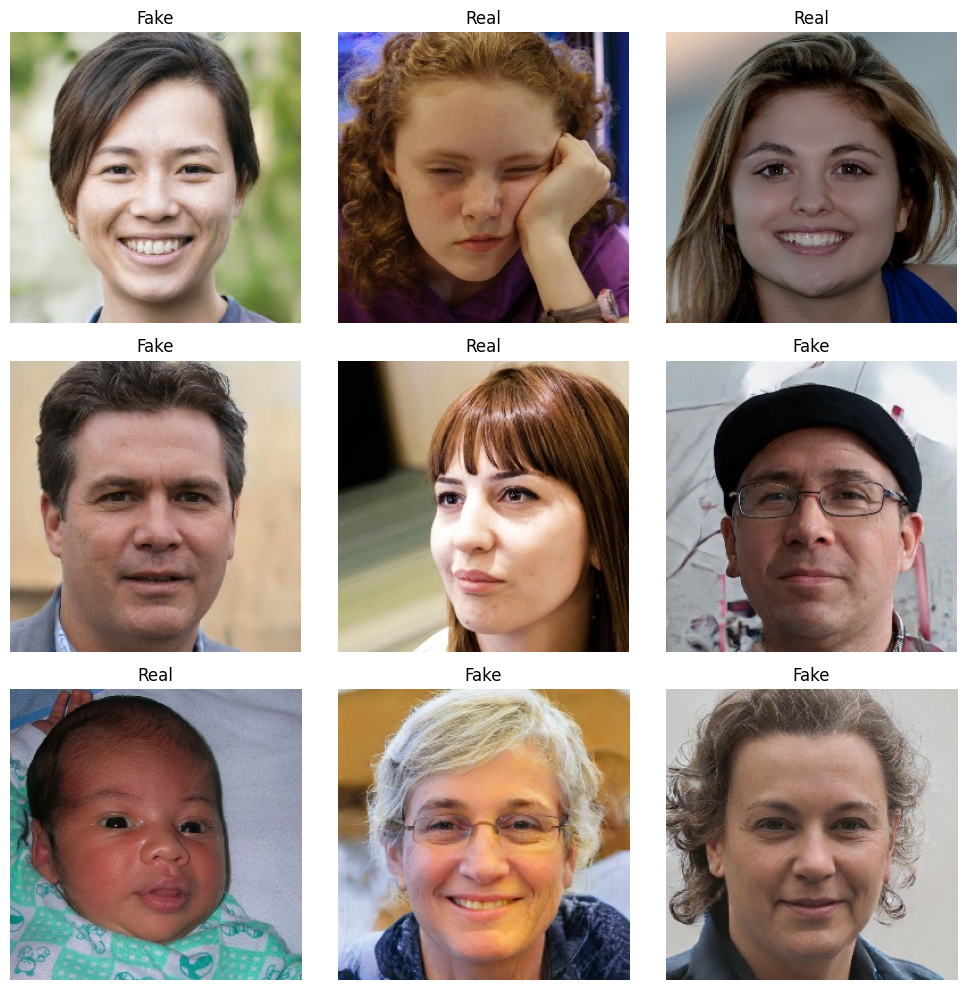

In [9]:
# Display 9 random images in a 3x3 grid
display_images(train_paths[:9], train_labels[:9])
plt.tight_layout()

In [10]:
# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [22]:
# Function to apply transformations and convert to DataLoader format
def transform_and_loader(image_paths, labels, batch_size=32, train=True):
    if train:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomRotation(degrees=20),
            transforms.RandomHorizontalFlip(p=0.6),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    dataset = CustomDataset(image_paths, labels, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=train)
    return loader

In [23]:
# Apply transformations and convert to DataLoader format for train and test data
trainloader = transform_and_loader(train_paths, train_labels, train=True)
validloader = transform_and_loader(val_paths, val_labels, train=False)
testloader = transform_and_loader(test_paths, test_labels, train=False)

In [24]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
# Modify the last fully connected layer to match the number of classes
num_classes = 2  # Assuming binary classification (real vs fake)
num_epochs=10

model=models.resnet18()
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the device
model = model.to(device)

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [27]:
#Create a directory.
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)
create_dir("files")

checkpoint_path = "files/checkpoint.pth"

In [28]:
# Function to train the model and evaluate on test data
def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    best_valid_loss = float('inf')
    for epoch in range(num_epochs):
        # Training phase
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc_train = correct_train / total_train
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc_train:.4f}')

        # Evaluation phase
        model.eval()  # Set the model to evaluation mode
        running_loss_test = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                # Move data to device
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Update statistics
                running_loss_test += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        epoch_loss_test = running_loss_test / len(test_loader.dataset)
        epoch_acc_test = correct_test / total_test
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {epoch_loss_test:.4f}, Validation Accuracy: {epoch_acc_test:.4f}')

        # Save model checkpoint if validation loss improves
        if epoch_loss_test < best_valid_loss:
            best_valid_loss = epoch_loss_test
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Saving model checkpoint at epoch {epoch+1}')

In [29]:
train_and_evaluate_model(model, trainloader, validloader, loss_fn, optimizer, num_epochs)

Epoch [1/10], Train Loss: 0.5756, Train Accuracy: 0.6901
Epoch [1/10], Validation Loss: 0.5574, Validation Accuracy: 0.7429
Saving model checkpoint at epoch 1
Epoch [2/10], Train Loss: 0.3847, Train Accuracy: 0.8274
Epoch [2/10], Validation Loss: 0.2899, Validation Accuracy: 0.8782
Saving model checkpoint at epoch 2
Epoch [3/10], Train Loss: 0.2720, Train Accuracy: 0.8859
Epoch [3/10], Validation Loss: 0.2539, Validation Accuracy: 0.8942
Saving model checkpoint at epoch 3
Epoch [4/10], Train Loss: 0.2088, Train Accuracy: 0.9150
Epoch [4/10], Validation Loss: 0.2248, Validation Accuracy: 0.9103
Saving model checkpoint at epoch 4
Epoch [5/10], Train Loss: 0.1635, Train Accuracy: 0.9354
Epoch [5/10], Validation Loss: 0.1671, Validation Accuracy: 0.9345
Saving model checkpoint at epoch 5
Epoch [6/10], Train Loss: 0.1334, Train Accuracy: 0.9477
Epoch [6/10], Validation Loss: 0.1318, Validation Accuracy: 0.9460
Saving model checkpoint at epoch 6
Epoch [7/10], Train Loss: 0.1104, Train Accura

In [37]:
# Function to load a saved model checkpoint and evaluate on test data
def evaluate_saved_model(model, testloader, criterion, checkpoint_path):
    # Load the saved model checkpoint
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()  # Set the model to evaluation mode

    correct, total, running_loss = 0, 0, 0.0

    # Evaluate on test data
    with torch.no_grad():
        for images, labels in testloader:
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Update statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy and average loss
    test_accuracy = correct / total
    test_loss = running_loss / len(testloader.dataset)

    # Print the accuracy and loss
    print(f'Test Accuracy: {test_accuracy:.3f}')

In [38]:
evaluate_saved_model(model, testloader, loss_fn, checkpoint_path)

Test Accuracy: 0.966
